In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import statsmodels.api as sm
import warnings
import geopandas as gpd
import shapely as shp
warnings.filterwarnings('ignore')


# All parameter in csv files:
# ["State_Name","District_Name","Crop_Year","Season","Crop","Area","Production"]

# select Parameter to Analyse:
parameter = "District_Name"

# Path for csv file:
file_path = r'Crop_Production_data.csv'

# Read the CSV file into a pandas DataFrame:
df = pd.read_csv(file_path)

df.isna().sum()


State_Name          0
District_Name       0
Crop_Year           0
Season              0
Crop                0
Area                0
Production       3730
dtype: int64

In [ ]:
official_states_ut = ["andhra pradesh", "arunachal pradesh", "assam", "bihar", "chhattisgarh", "goa", "gujarat", "haryana", "himachal pradesh", "jharkhand", "karnataka",
    "kerala", "madhya pradesh", "maharashtra", "manipur", "meghalaya", "mizoram", "nagaland", "odisha", "punjab", "rajasthan", "sikkim",
    "tamil nadu", "telangana", "tripura", "uttar pradesh", "uttarakhand", "west bengal", "andaman and nicobar", "chandigarh",
    "dadra and nagar haveli", "delhi", "jammu and kashmir", "ladakh", "lakshadweep", "puducherry"]

# Convert each state/UT name to title case
formatted_states_ut = [state.title() for state in official_states_ut]

# Replace the name of Odisha with Orissa in the 'State_Name' column
#df['State_Name'] = df['State_Name'].replace('Odisha','orissa')
#df['State_Name'] = df['State_Name'].replace('Uttarakhand','uttaranchal')


# Normalize state names (case-insensitive and remove leading/trailing whitespaces)
df['State_Name'] = df['State_Name'].str.strip().str.title()

# Count unique states
unique_states_count = df['State_Name'].nunique()
print(f"Number of unique states in the data: {unique_states_count}")

# List all unique states
unique_states = df['State_Name'].unique()

# Print the result
print(f"Number of unique states in the data: {unique_states_count}")

# Find missing states/UTs
missing_states_ut = set(formatted_states_ut) - set(unique_states)

# Print the missing states/UTs
print(f"Missing states or union territories: {missing_states_ut}")


Number of unique states in the data: 33
Number of unique states in the data: 33
Missing states or union territories: {'Ladakh', 'Lakshadweep', 'Delhi'}


In [3]:

# The original index (state names) becomes a column and the counts become another column.
# The new DataFrame has default integer indices.
state_counts = df['State_Name'].value_counts().reset_index()
state_counts.columns = ['State_Name', 'Count']

# Set index to state names
#data.set_index('State_Name', inplace=True)

total_entries = len(df)
percentage_contribution = (state_counts['Count'] / total_entries) * 100
state_counts['Percentage'] = percentage_contribution

# Add Missing states and UT as zero percentage:
# {'Lakshadweep', 'Ladakh', 'Delhi'}

new_state = {'State_Name': 'Lakshadweep', 'Count': 0, 'Percentage': 0.0}
state_counts.loc[len(state_counts)] = new_state
new_state = {'State_Name': 'Ladakh', 'Count': 0, 'Percentage': 0.0}
state_counts.loc[len(state_counts)] = new_state
new_state = {'State_Name': 'Delhi', 'Count': 0, 'Percentage': 0.0}
state_counts.loc[len(state_counts)] = new_state

state_counts = state_counts.sort_values(by='Percentage',ascending=True)

# Print the state percentage count
#print(state_counts)

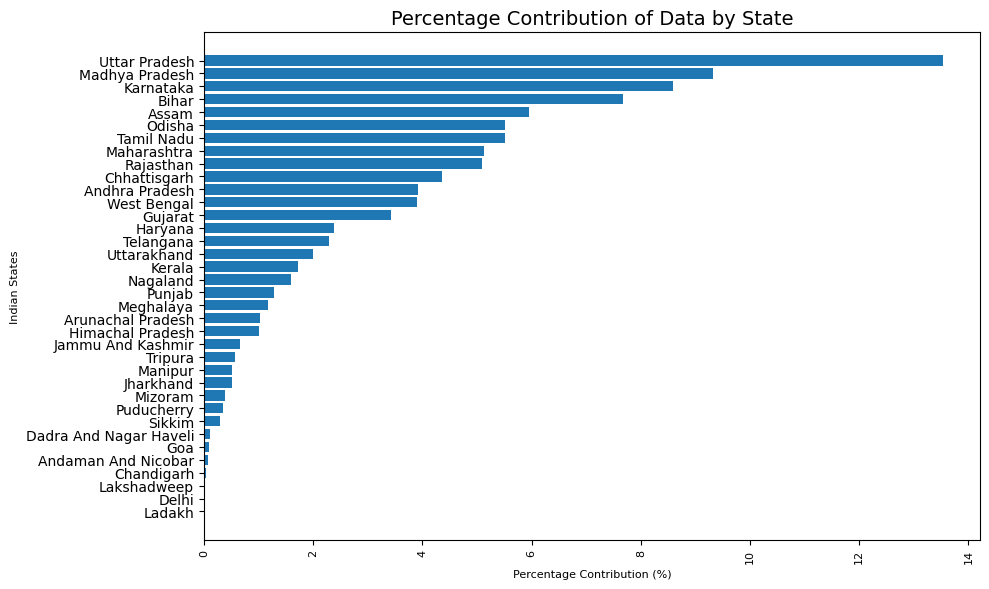

In [4]:
# Plotting state wise data contribution:
plt.figure(figsize=(10, 6))

key = state_counts['State_Name']
value = state_counts['Percentage']

plt.barh(key, value)
plt.title('Percentage Contribution of Data by State', fontsize=14)
plt.ylabel('Indian States', fontsize=8)
plt.xlabel('Percentage Contribution (%)', fontsize=8)
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()


<Figure size 1000x1000 with 0 Axes>

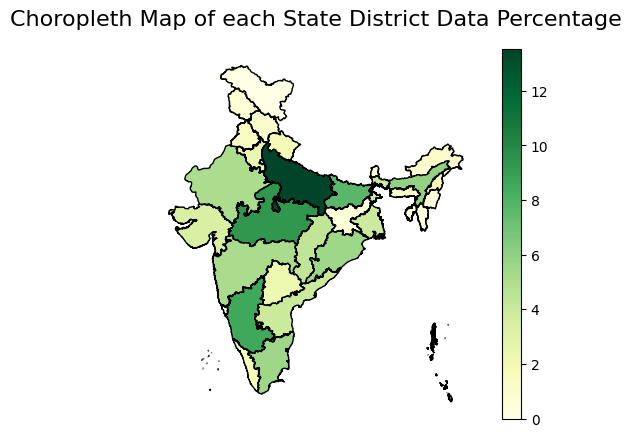

In [ ]:

# Load the shapefile file for state district boundaries
shapefile_path = "map\STATE_BOUNDARY_Corrected.shp"
geo_data = gpd.read_file(shapefile_path)

state_counts['State_Name'] = state_counts['State_Name'].str.upper()

state_counts['State_Name'] = state_counts['State_Name'].replace('ANDAMAN AND NICOBAR', 'ANDAMAN & NICOBAR')

# Merge the GeoDataFrame with the CSV data
# Replace 'state_column_in_shapefile' with the column name in your shapefile that matches state names
merged_data = geo_data.merge(state_counts, left_on='STATE', right_on='State_Name', how='left')  


# Plot the choropleth map (District wise data yet to be calcuate for percentage)
plt.figure(figsize=(10, 10))
merged_data.plot(column='Percentage', cmap='YlGn', legend=True, edgecolor='black')
plt.title('Choropleth Map of each State District Data Percentage', fontsize=16)
plt.axis('off')
plt.show()

#coolwarm

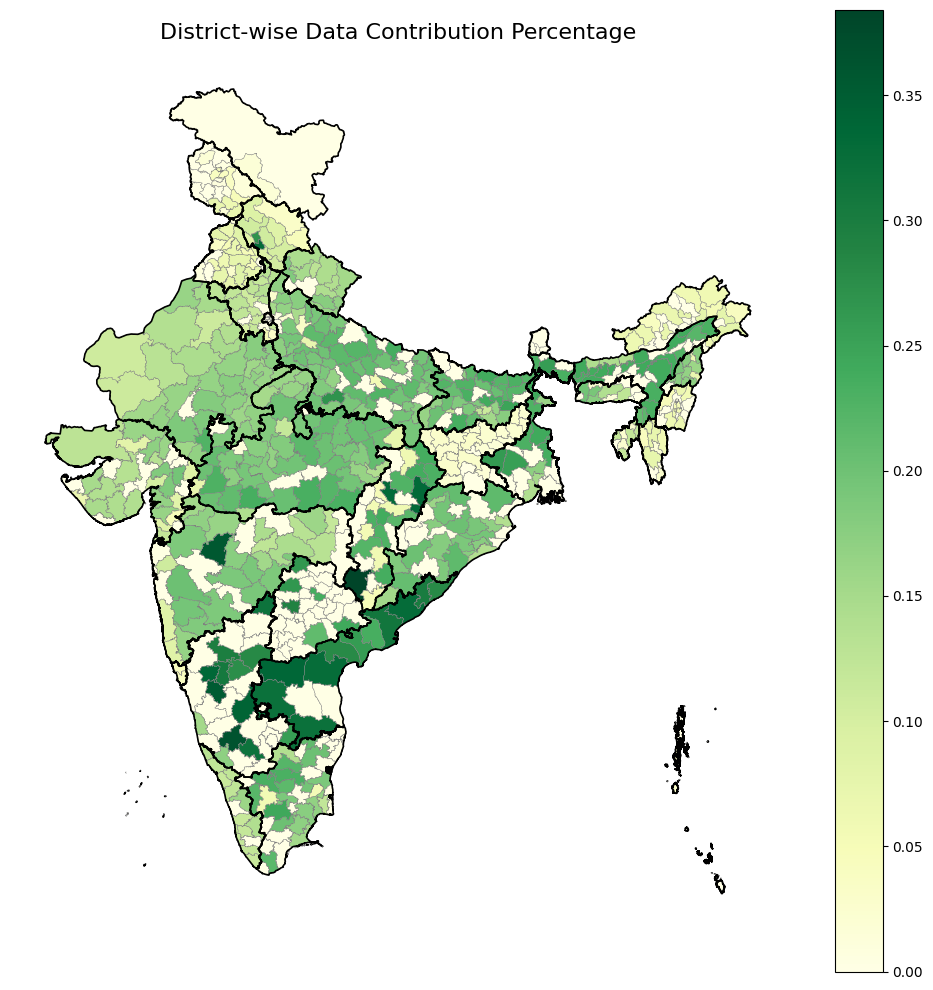

In [13]:


# 1. Count district appearances
district_counts = df['District_Name'].value_counts().reset_index()
district_counts.columns = ['District_Name', 'Count']

# Replace the name of Odisha with Orissa in the 'State_Name' column
#df['State_Name'] = df['State_Name'].replace('Odisha','orissa')
#df['State_Name'] = df['State_Name'].replace('Uttarakhand','uttaranchal')

# 2. Calculate percentage contribution
total_entries = len(df)
district_counts['Percentage'] = (district_counts['Count'] / total_entries) * 100

# 3. Load India districts shapefile (replace with your path)
shp_path = "map\DISTRICT_BOUNDARY_Corrected.shp"
gdf = gpd.read_file(shp_path)

states_gdf = gpd.read_file("map\STATE_BOUNDARY_Corrected.shp")


gdf["District"] = gdf["District"].str.strip().str.upper()
gdf["STATE"] = gdf["STATE"].str.strip().str.upper()  # State column in shapefile

# 4. Clean and merge data
# Normalize district names in both datasets
district_counts['District_Name'] = district_counts['District_Name'].str.strip().str.title()

district_counts['District_Name'] = district_counts['District_Name'].str.upper()

# Merge datasets
merged = gdf.merge(district_counts, 
                 left_on='District', 
                 right_on='District_Name', 
                 how='left')

# Handle missing values
merged['Percentage'] = merged['Percentage'].fillna(0)

# 6. Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Plot districts colored by percentage
merged.plot(column='Percentage', cmap='YlGn', legend=True, ax=ax, edgecolor='grey', linewidth=0.3)
# Overlay state boundaries
states_gdf.boundary.plot(ax=ax, color='black', linewidth=1.2)

plt.title('District-wise Data Contribution Percentage', fontsize=16)
plt.axis('off')


plt.tight_layout()
plt.show()
